# Visualisation of gridded Lightning Imager (LI) products
<br> 
<br> 
<br> 
Blanka Gvoždíková, Jindřich Šťástka <br> 
blanka.gvozdikova@chmi.cz

- Based on September 2021 LI test data release
- point / gridded
- gridded flash accumulations within FCI 2km grid in 30 s time interval
<br> 
<br> 
- 3 types of accumulations:
 - Accumulated flash area
 - Accumulated flash?
 - Accumulated flash radiance

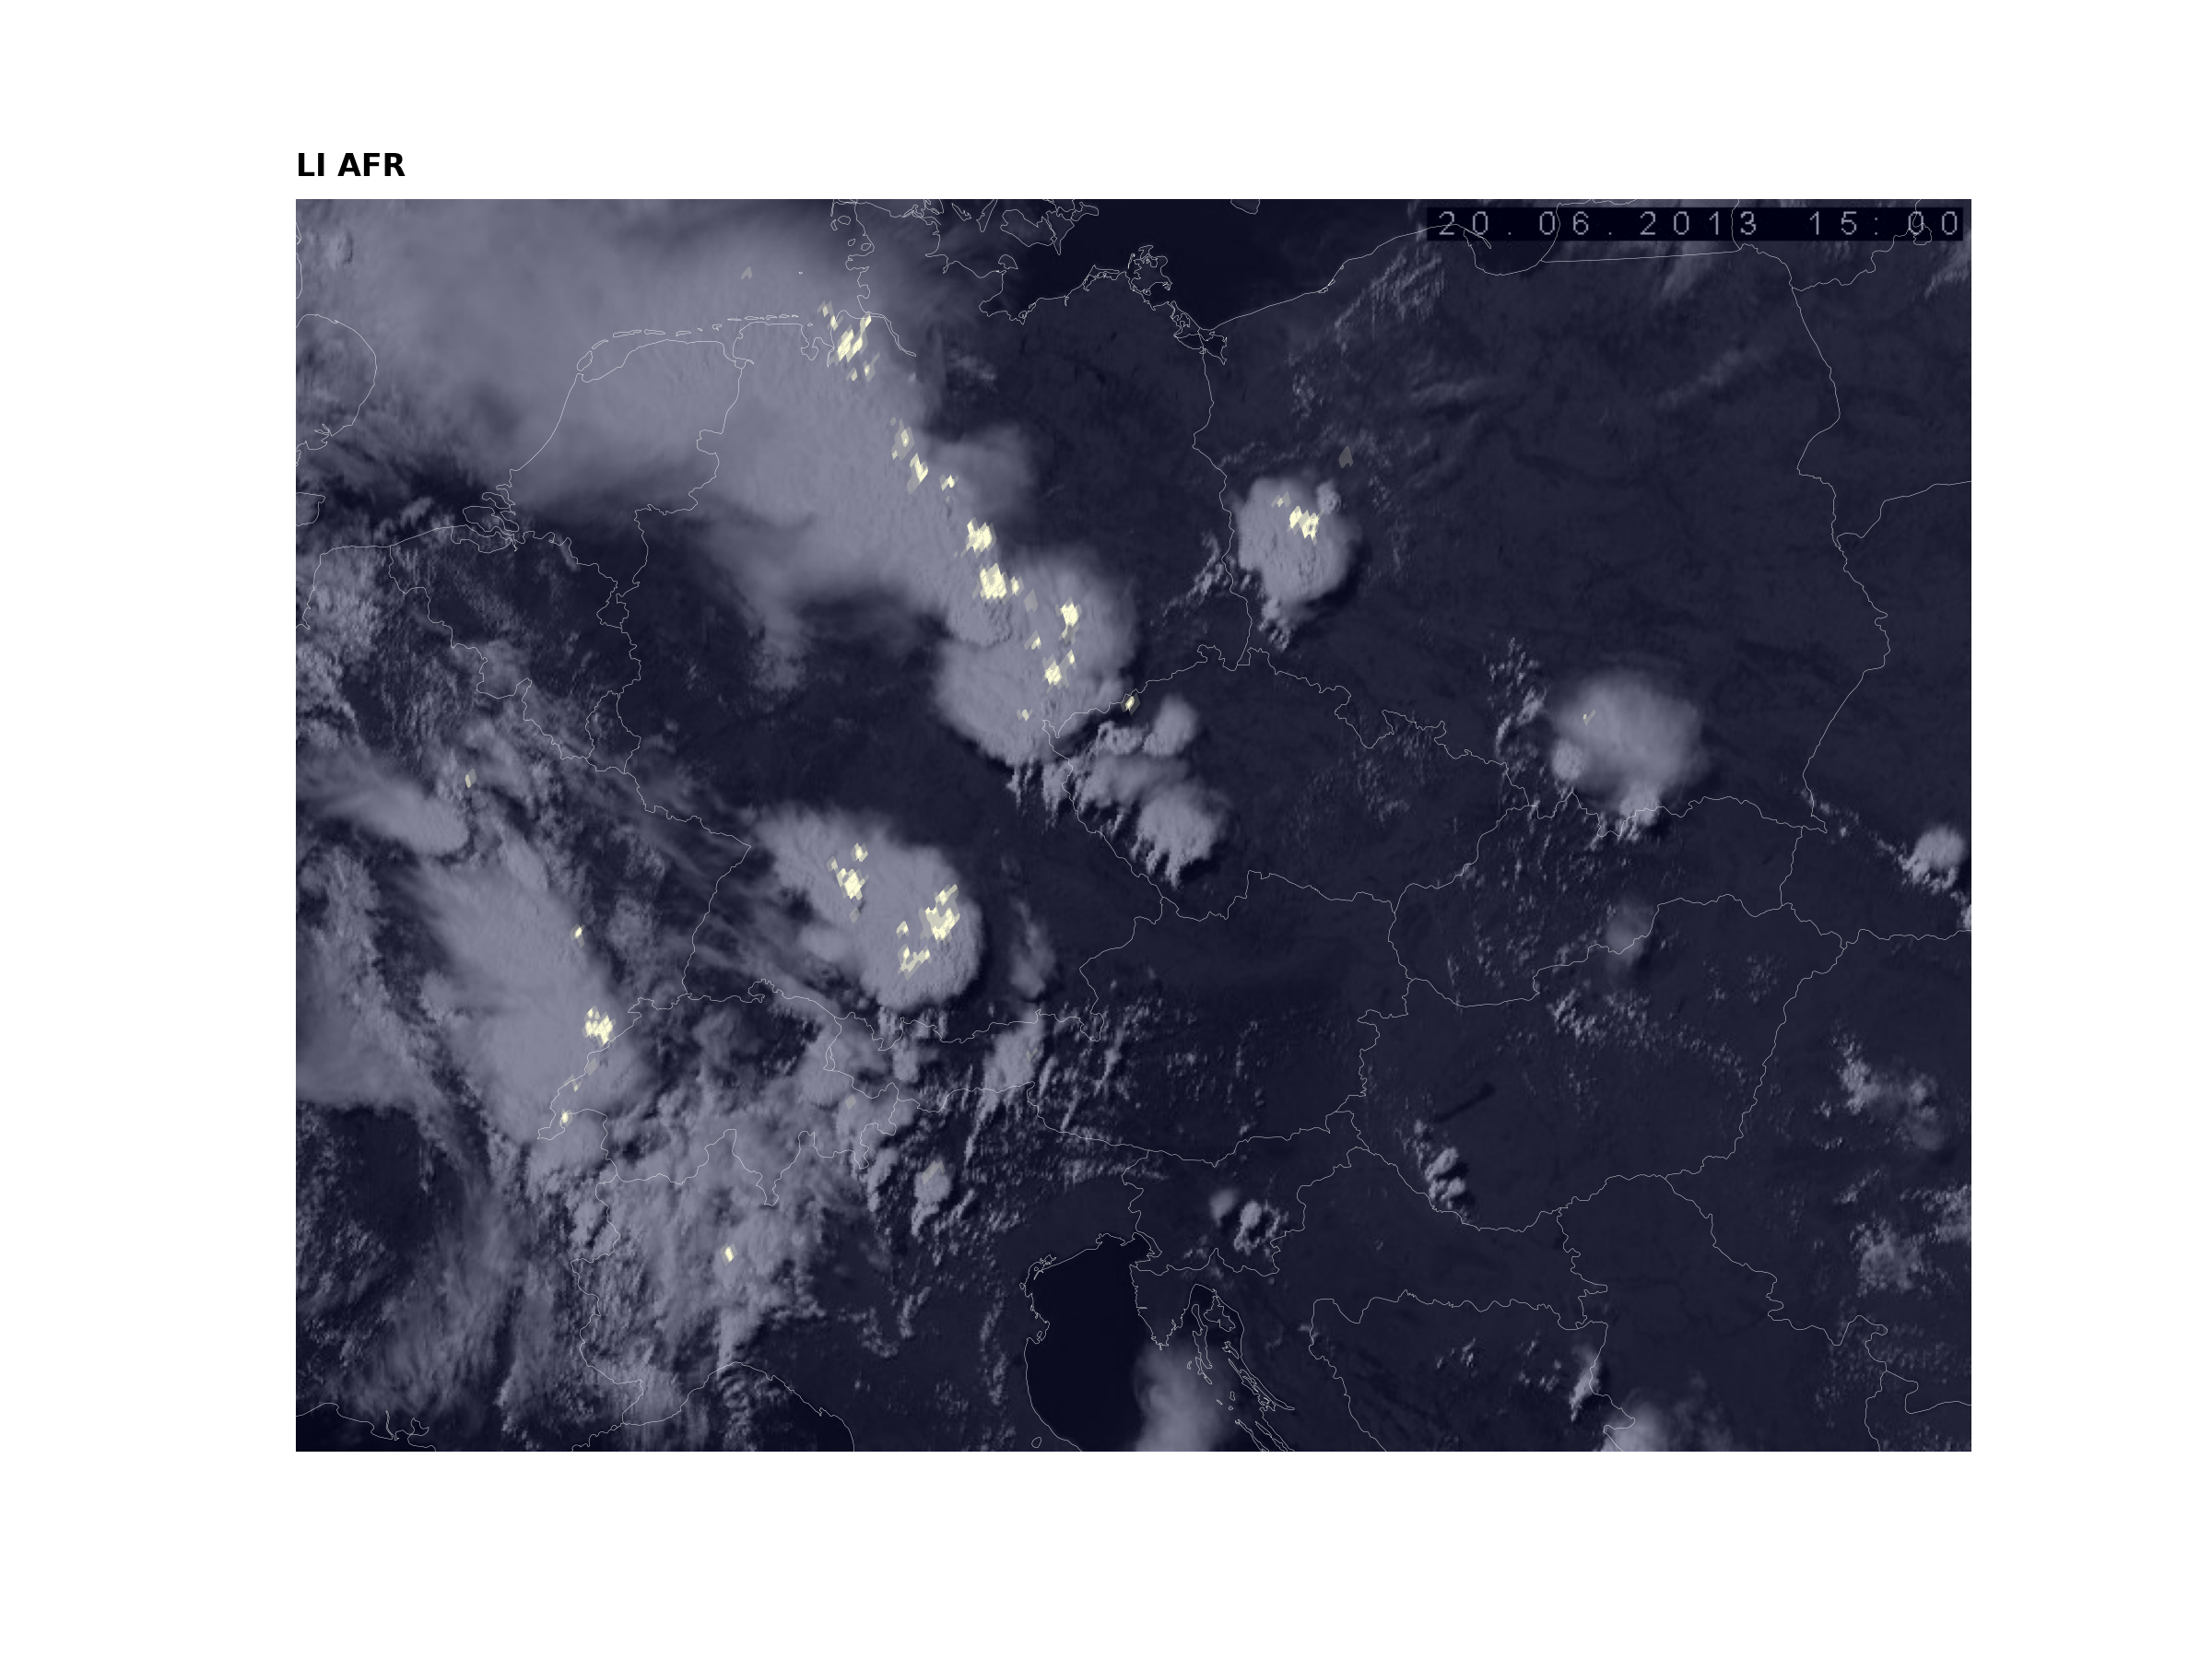

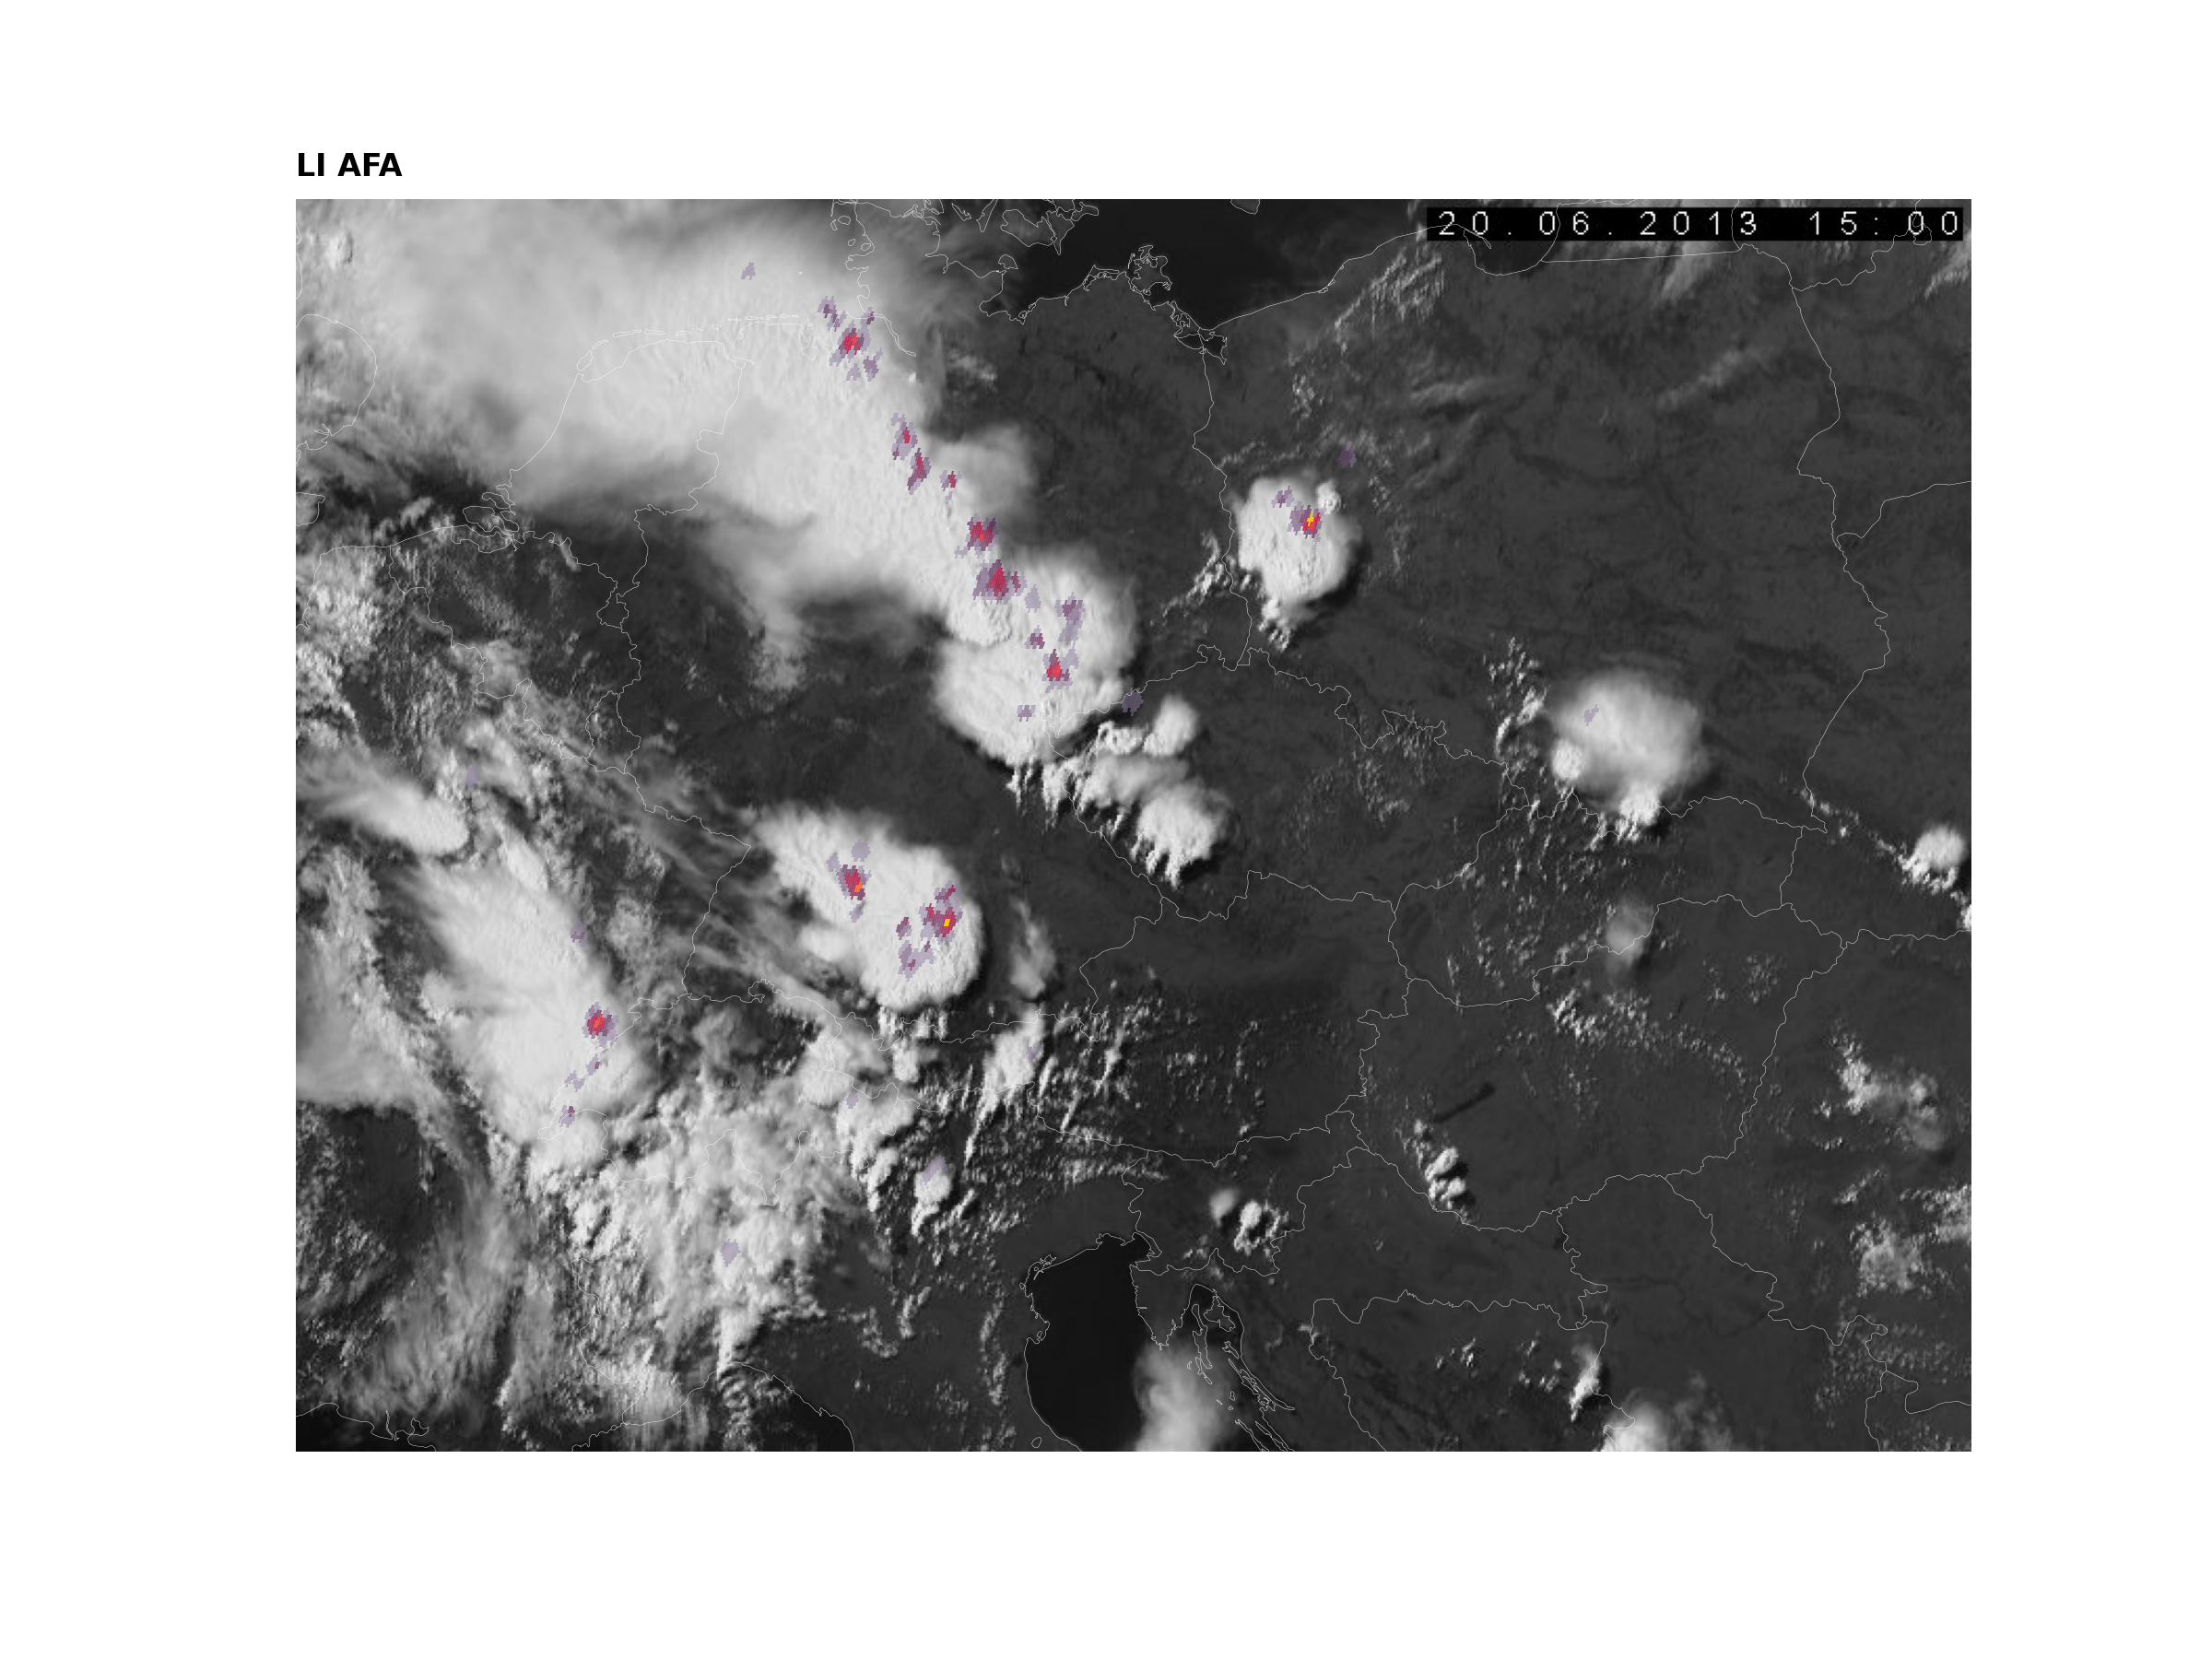

#### 1 Necessary imports and loading product files

In [ ]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Proj
import cartopy
import cartopy.feature as cf
from glob import glob
import os

In [ ]:
# Product file directory
file_dir = '/L2_run_flashes_201306201500_201306201501/'
os.chdir(file_dir)

# Loading dataset
for fname in glob('W_XX-EUMETSAT-DARMSTADT,IMG+SAT,MTI1+LI-2-AFA*'):
    file=fname
    ds=Dataset(file, 'r')

#### 2 Access some variables

In [ ]:
# Datetime of image scan
add_seconds = ds.variables['accumulation_start_times'][0]
DATE = datetime(2000, 1, 1, 0) + timedelta(seconds=add_seconds.data.tolist())

# Earth radius
r_eq = float(ds.variables['mtg_geos_projection'].semi_major_axis)
r_pol = float(ds.variables['mtg_geos_projection'].semi_minor_axis)

# Satellite height + Earth radius
sat_h = float(ds.variables['mtg_geos_projection'].perspective_point_height)

# Satellite longitude
sat_lon = float(ds.variables['mtg_geos_projection'].longitude_of_projection_origin)

# Satellite sweep
sat_sweep = ds.variables['mtg_geos_projection'].sweep_angle_axis

# Scale factor = Azimuth/Zenith grid sampling, same for 'x' and 'y'
scale_factor=ds.variables['x'].scale_factor

# Add offset = azimuth and zenith angles from  the centre of the projection to the centre of the pixel
add_offset=ds.variables['x'].add_offset

# Accumulated flash area; X_rad -> azimuth in radians, Y_rad -> zenith in radians
AFA = ds.variables['accumulated_flash_area'][:].data 
X_rad = ds.variables['x'][:].data
Y_rad = ds.variables['y'][:].data

#### 3 Latitude/longitude calculation from satellite radian angle vectors

In [ ]:
# Number of columns/rows in full disc
col = np.arange(1, 5569)
row = np.arange(1, 5569)

# Calculation of all azimuth and zenith angles in full disc
a=-add_offset-(col-1)*scale_factor #negative from E to W
z=add_offset+(row-1)*scale_factor #negative from S to N

# Create meshgrid
aa, zz = np.meshgrid(a, z)

# lat/lon calculation routine
s4=(r_eq**2.0)/(r_pol**2.0)
s5=(sat_h**2.0)-(r_eq**2.0)
s_d=np.sqrt((sat_h*np.cos(aa)*np.cos(zz))**2-(np.cos(zz)**2.0+s4*(np.sin(zz)**2.0))*s5)
s_n=(sat_h*np.cos(aa)*np.cos(zz)-s_d)/((np.cos(zz))**2.0+s4*(np.sin(zz)**2.0))
s1=sat_h-s_n*np.cos(aa)*np.cos(zz)
s2=-s_n*np.sin(aa)*np.cos(zz)
s3=s_n*np.sin(zz)
s_xy=np.sqrt(s1**2.0+s2**2.0)
lon=(np.arctan(s2/s1)*180.0)/np.pi
lat=(np.arctan(s4*(s3/s_xy))*180.0)/np.pi

#### 4 Localization of 1D flash accumulation data in 2D full disc

In [ ]:
# Create dictionary of azimuth/zenith values and its indices
dic_a = {item: idx for idx, item in enumerate(-a)}
dic_z = {item: idx for idx, item in enumerate(z)}

# Get indices of azimuth/zenith matching the values in X_rad/Y_rad
a_idx = np.array([dic_a.get(item) for item in X_rad])
z_idx = np.array([dic_z.get(item) for item in Y_rad])

# Localize flash accumulation data in full disc grid
full_AFA = np.empty(a.shape + z.shape)
full_AFA.fill(np.nan)
full_AFA[z_idx, a_idx] = AFA

#### 5 Projecting the data

In [ ]:
projection=cartopy.crs.Stereographic(central_latitude=90, central_longitude=15, 
                                     false_easting=1082174.131326, false_northing=4014747.106985)

# Corners
llx=0
lly=-1420239.633
urx=1899679.7888
ury=0

p=Proj(projection.proj4_init)
x,y = p(lon,lat)

# Replace inf values with zero
x0=np.nan_to_num(x, posinf=0)
y0=np.nan_to_num(y, posinf=0)

#### 6 Display figure

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_extent([ury, urx, lly, llx], crs=projection)
ax.add_feature(cf.COASTLINE, edgecolor='w', linewidth=0.1)
ax.add_feature(cf.BORDERS, edgecolor='w', linewidth=0.1)
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

# Background image
image_filename='msgce.vis.20130620.1500.0.jpg'
img = plt.imread(image_filename)
img_extent = (llx, urx, lly, ury)
ax.imshow(img, origin="upper", extent=img_extent, transform=projection)

# Add accumulation flash data
colors=[(0.7,0.7,0.8,0.5), (0.3,0.1,0.3,0.6), (0.6,0.0,0.2,0.7), (0.8,0.0,0.2,0.8), 
        (1.0,0.3,0.2,0.9), (1.0,0.8,0.0,1.0), (1.0,1.0,0.0,1.0), (1.0,1.0,1.0,1.0)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=256)
plt.pcolor(x0, y0, full_AFA, transform=projection, cmap=cmap, snap=True, 
           edgecolors=(0,0,0,0.3), linewidth=0.000001, vmin=0, vmax=20)

plt.title('LI AFA', fontweight='semibold', loc='left', fontsize=8)
plt.savefig('afa.png')

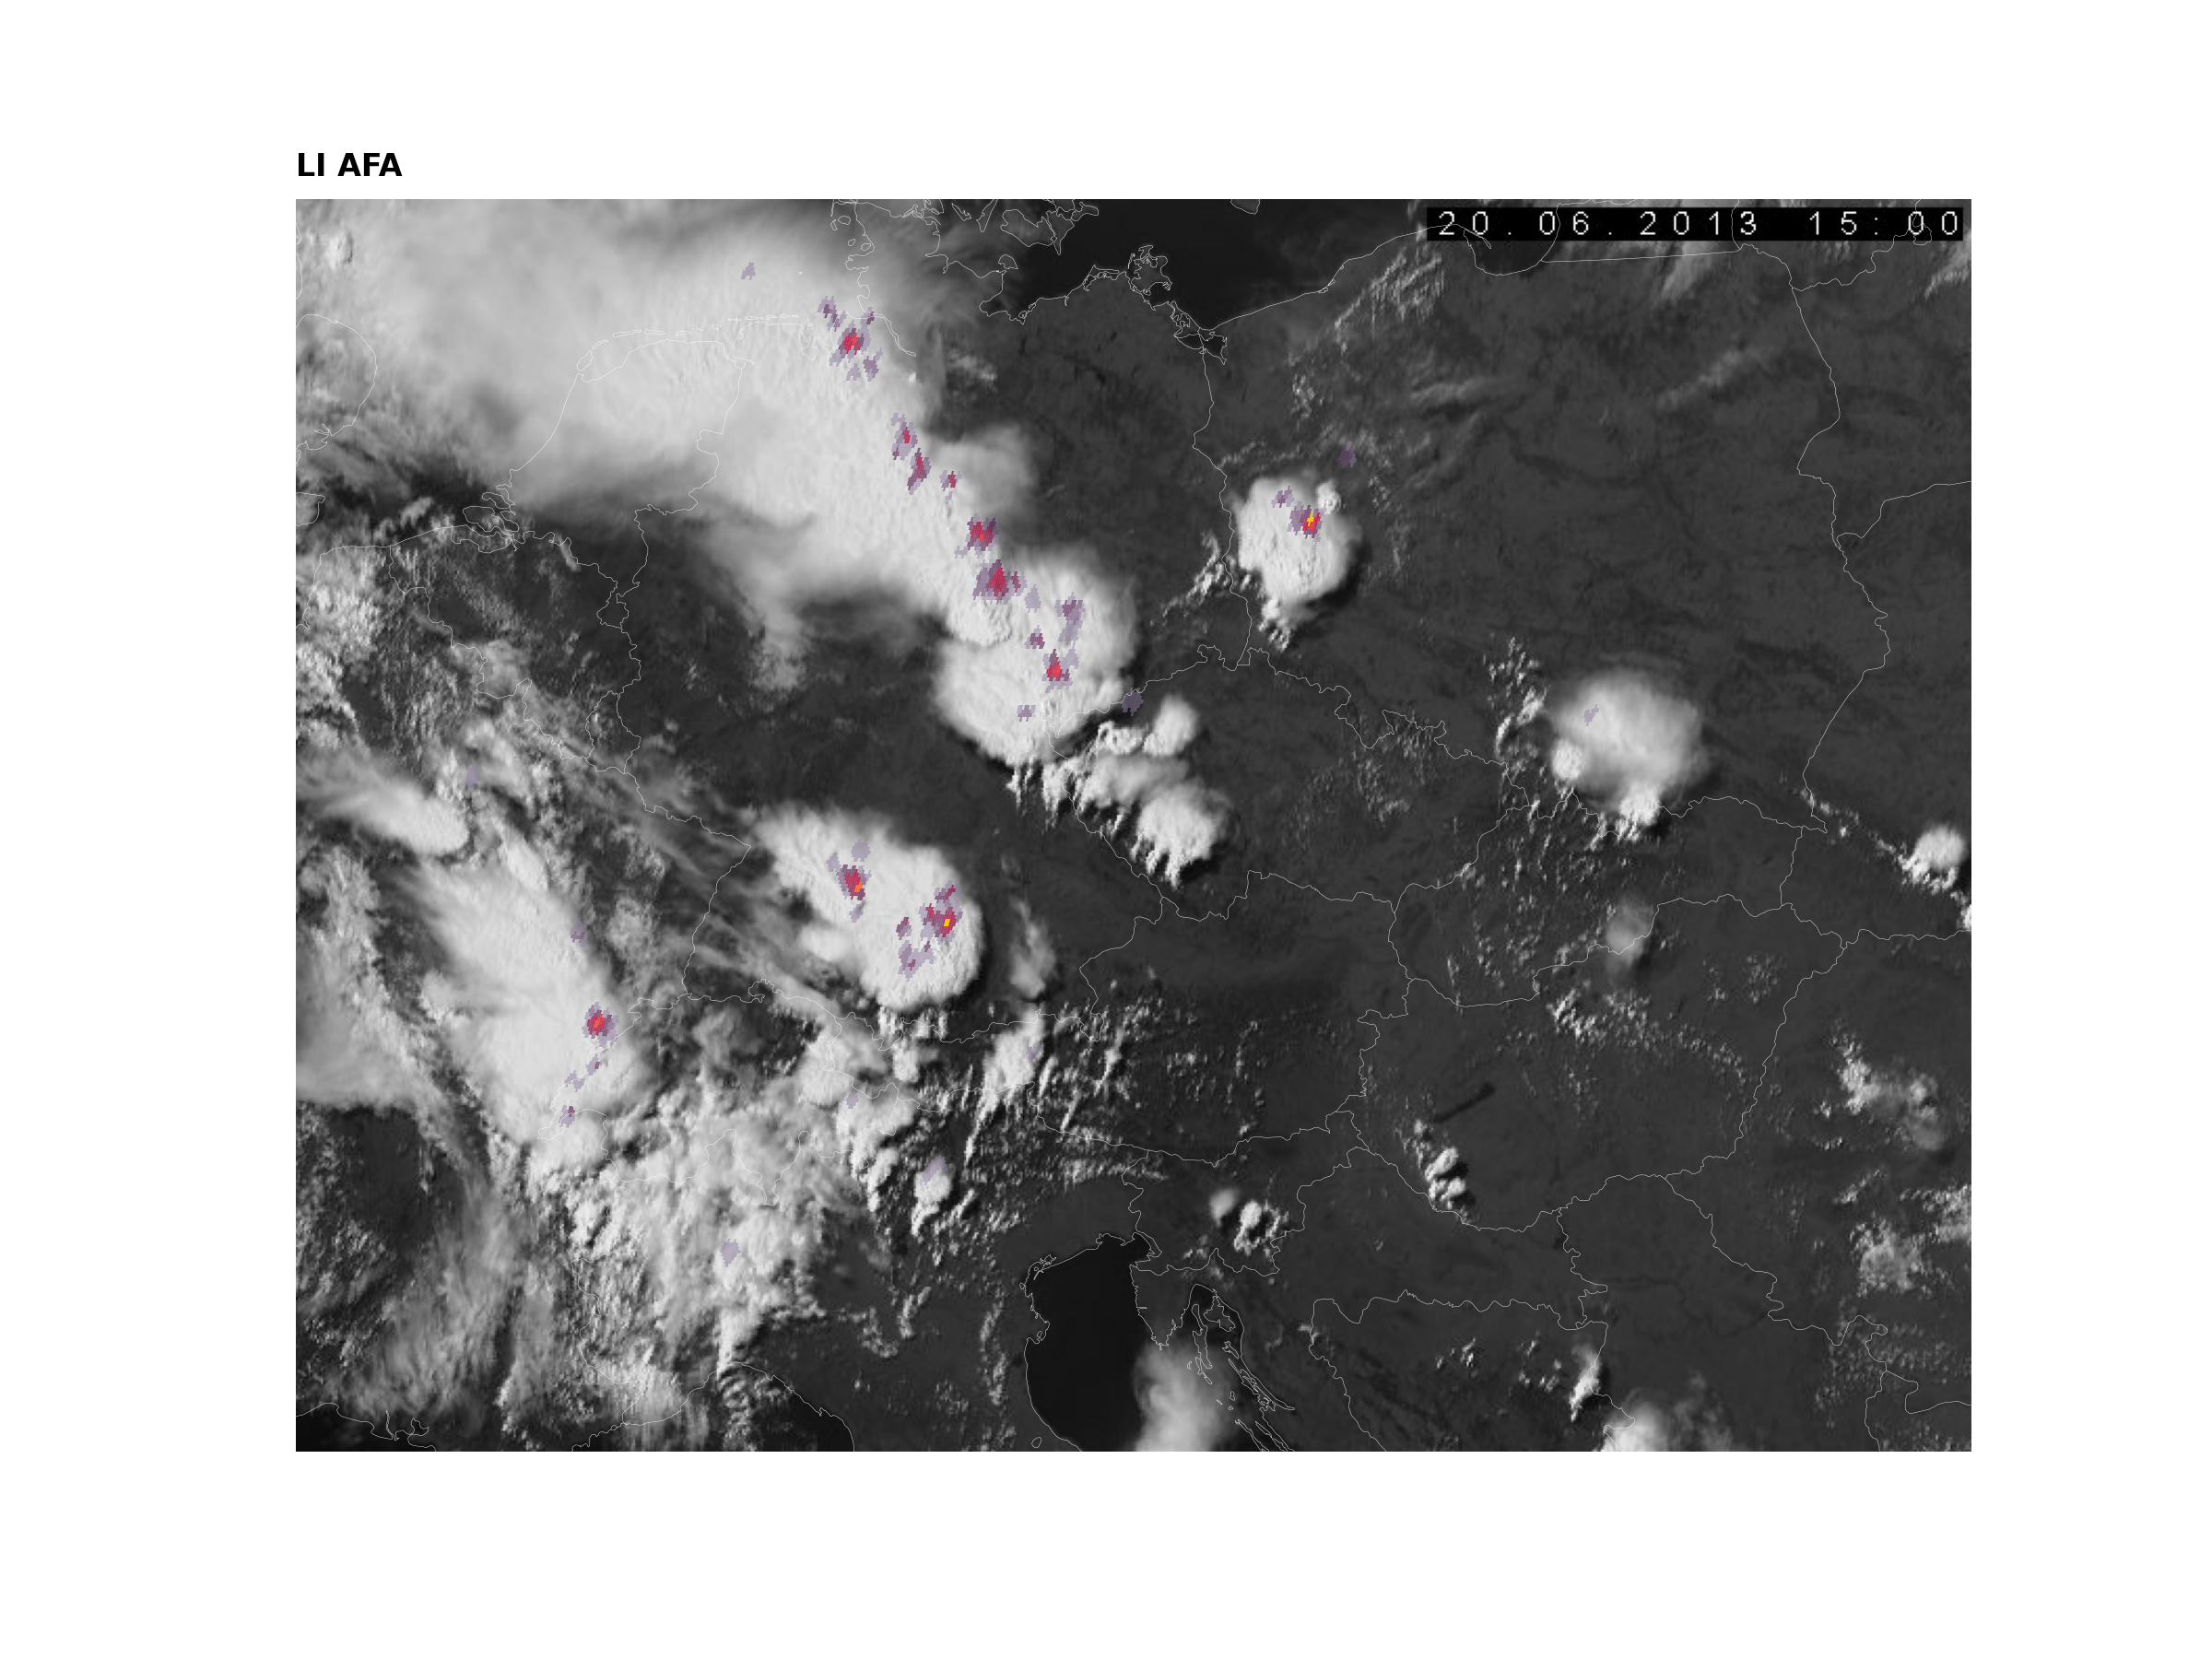

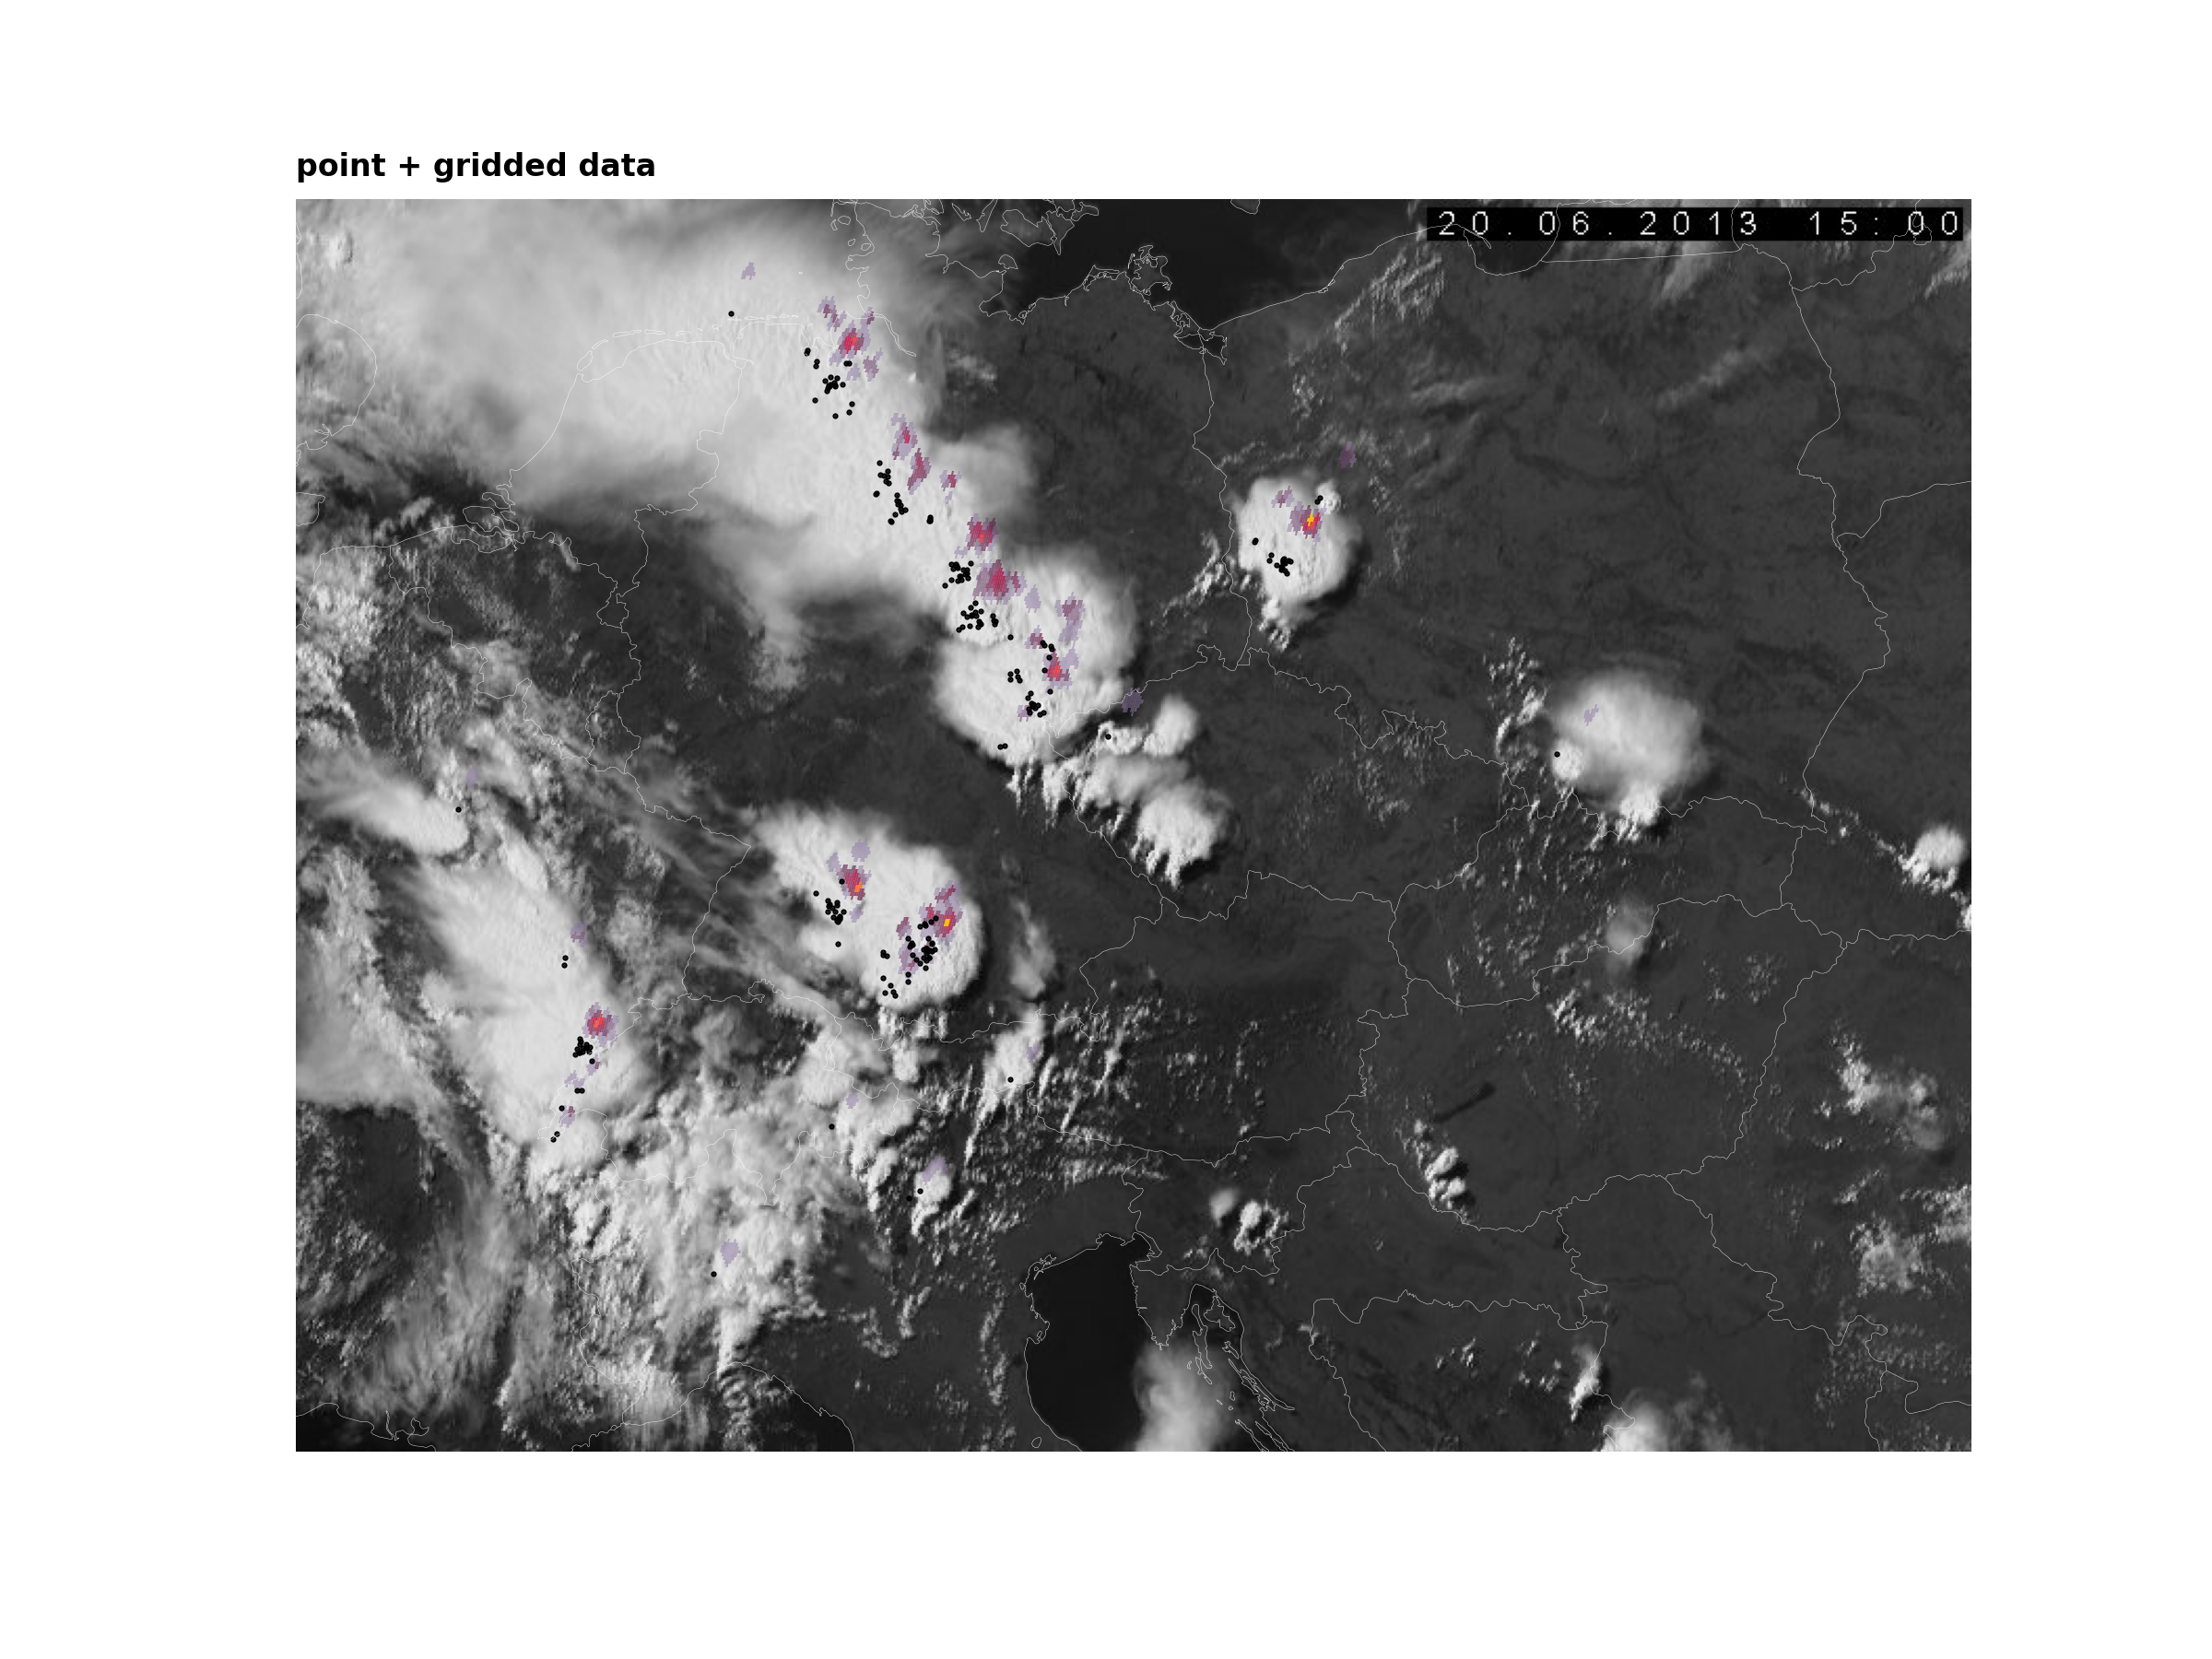